In [1]:
!pip install scikit-multilearn transformers accelerate sentencepiece datasets  -q
!pip install faiss-cpu -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 38.9 MB/s eta 0:00:00


In [2]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [3]:

cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [4]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [5]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T


,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


In [6]:
#Explode labels column that find the most frequent:

df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# Display the top-8 label categories
df_counts.to_frame().head(8).T

Number of labels: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


In [7]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [8]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [9]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [10]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [11]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [12]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


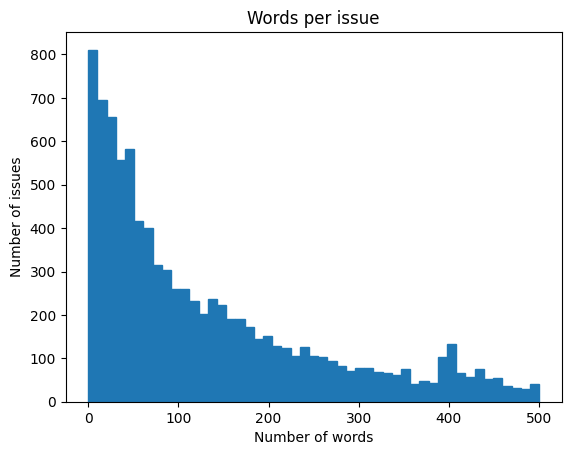

In [13]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len)
 .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

In [14]:

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [15]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [16]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [17]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

In [18]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [19]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


# Implementing Naive Bayesline

Whenever you start a new NLP porject, it's always a good idea to implement as et of strong baselines 2 reason:
1. A baseline based on regular expression, handcrafted rules, or a very simple modle might alreaay work relly well to solve the problem. In these cases there is no reason to bring out big guns like transformers
2. Baselines provide quick check as you explore moree complex model. For example suppose you train BERT-large and get an accuracy of.8 on your validation set. You mijght write it off as a hard dataset and call it a day. But what if you knew that a simple classifier like logistice regression gets .95 accuracy?

In [20]:
## IMPLEMENTING NAIVE BAYESLINE


def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [21]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])


- We get the trainin slice and encode the labels
- We use a count vectorizer to encode the texts by simply creating a vector of size of the vocabulary where each entry corresponds to the frequency with whcih a token appeared in the text- This is called a bag-of-words approach, sinc all information on the order of the words is lost.
-Then we train the classifier and use the predictions on the tes set to ge the micro and macro F1_scores via classification report

In [23]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

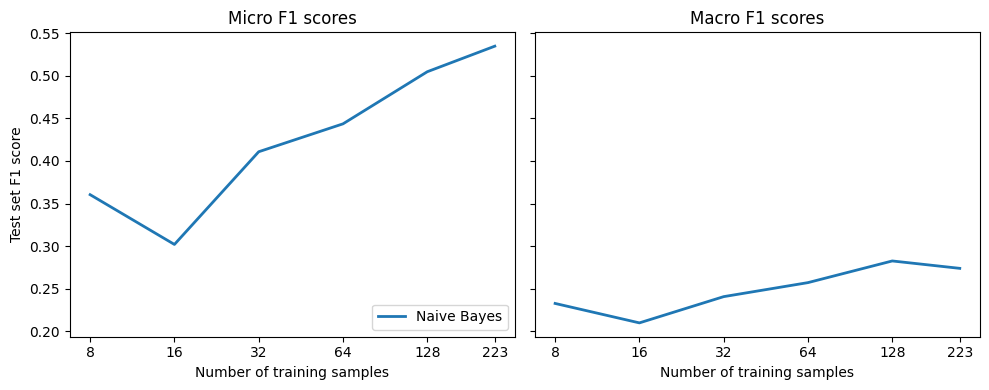

In [24]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")


## Working with No labeled Data
- Zero - shhot classification, the goal here is to make use of a pretrained model without any additional fine-tuning on your task-specific corpus
    - To get a better ide of how this could work, recall that language models like BERT are pretrained to predict Masked tokens in text of thousands of books and large Wikipedia dumpts
    - To successfully predict a missing token, the model needs to be aware of the topic in th exontext
    - We can try to trcik the modle insto classifying a document for us by providing a sentnece like:
        " This section was about the topic [MASK]

        - The model should then give a reasonable suggestion for the documents topic, since this a natural text to occur in the dataset

In [25]:

#hide_output
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:

movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token lions:	0.066%
Token birds:	0.025%
Token love:	0.015%
Token hunting:	0.013%


In [27]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token cars:	0.001%


In [28]:

movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cars:	0.139%
Token animals:	0.006%


In [29]:

from transformers import pipeline

pipe = pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [30]:
sample = ds["train"][0]
print(f"Labels: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [31]:
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

- Since the domain we are operating in is different from the domain the model trained on
- Define a threshold and select all labels above the threshold
Pick th etop k labels with the k highest scores

In [32]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [33]:

def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0,
        output_dict=True)


In [34]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                    fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

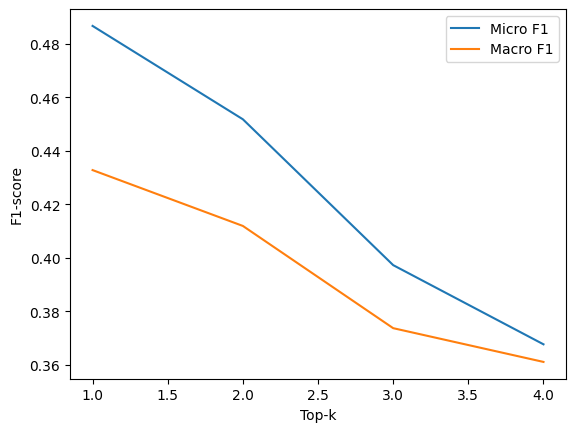

In [35]:
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()


In [36]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])


Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

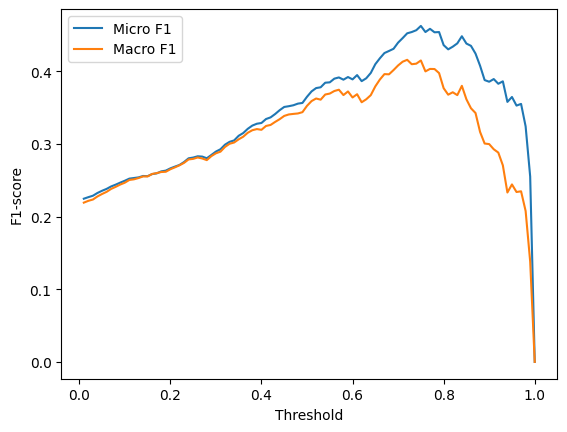

In [37]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [38]:

best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (micro): {best_t} with F1-score {best_macro:.2f}.')

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (micro): 0.72 with F1-score 0.42.


In [39]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

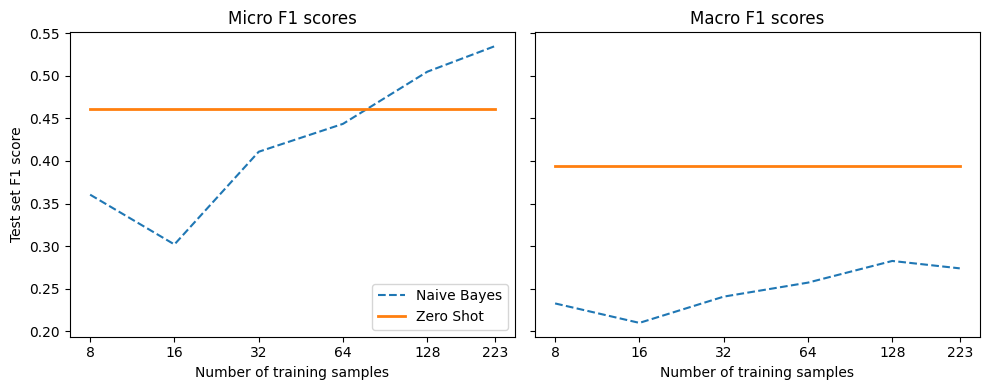

In [40]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")


## Comparing the zero-shot pipeline to the baseline ,we observe two things

- if we have less thna 50 labled samples, the zero-shot pipeline handily outperforms the baseline
- Even above 50 samples, the performance of the zero-shot pipeline is superior when considering both the miicro and macro F_1 scores tell us that the baseline performs well on the frequent classes, whil hte zero-shot pipeline excel at those it does not require any examples to learn from


### Improve Zero-Shot
- The way the pipeline works makes it very sensitive to the names of the labels if the names dont make muhc sense or are not easily connected to the texts, the pipeline will likely perform poorly. Either try using different names or use several names in parallel and aggregate them in extra step

- Another thing you can improve is the form of the hypothesis. By Default it is hpothesis= "this is example si about{}", but you can pass any other text to the pipeline. Depending on the use case, this mihgt improve the performance

## Working with Few Labels

- Data Augmentation
     - For text,if the text consists of more than few sentences, then the noise introduced by these types of transformations will generally not affect the label.
         - Back translation
             
             Take a text in the source language, translate it into one more target languages using machine translation tend to works best for high-resource languages or corpora that dont contain too many domain-specific words

        - Token perturbations
            Given a text from the traiing set , randomly choose and perform simple transformations like random synonym replacement, word insertion, swap, or deletion


In [41]:
!pip install nlpaug -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.2 MB/s eta 0:00:00


In [42]:
from transformers import set_seed
import nlpaug.augmenter.word as naw


set_seed(3)
aug=naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased')

text="Transformers are the most popular toys"

print(f"Original text:{text}")
print(f"Augmented text:{ aug.augment(text)}")


Original text:Transformers are the most popular toys
Augmented text:['transformers produce the most durable toys']


In [43]:

def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += [aug.augment(text)]
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

- From the figure, we can see that a small amount of data augmentation improves the F1 socere of the Naive Bayes classifier by around 5 point and it overtakes the zero shot pipeline for the macro scores once we have round 170 training samples. Let now take  alook at a method based on using the embeddings of large language models

### Using Embeddings as a Lookup Table
- We'll create  a text classifier that modeled after OpanAI API classification endpoint.
 1. Use the language model to embed all labeled texts
 2. Perform a nearest neighbor search over the stored embeddings
 3. Aggregate the labels of the nearest neighbors to get a prediction

- When a new text needs to be classified it is embedded as well, and the label is given based on the labels of the nearest neighbors.

- It is important to calibrate the number of neighbors to be searched for, as too few might be noisy and too many might mix in neighboring groups

- The beauty of this approach is that no model fine-tuning is necssary to leverage the few available labeled data points.
- Instead the main decision to make this approach work is to select an appropriate model that is ideally pretrained on a similar domian to your dataset


- Lets write a helper function that takes a list of texts and uses the model to create a single-vector represnetation for each text. One problem we have to deal with is that transformer models like GPT-2 will actaully return one embedding vector per token
    - For instance the sentence " I took my dog for a walk" , we can expect several embedding vector for the whole sentence
    - To deal with this we can use a technique called pooling, One of the simplest pooling methods is to average the token embeddings, which is called mean pooling.
    
    - With mean pooling,the only thing we need to watch out for is that we dont include padding tokens in the average, so we can use the attention mask to handle that

In [44]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}


In [45]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)


Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

In [46]:
embs_train.add_faiss_index("embedding")


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

In [47]:

i, k = 0, 3 # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QUERY LABELS: {embs_valid[i]['labels']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")


QUERY LABELS: ['new model']
QUERY TEXT:
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and [...]

Retrieved documents:
TEXT:
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La [...]
SCORE: 54.92
LABELS: ['new model']
TEXT:
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to Transformers library?
## Model description
The n [...]
SCORE: 57.90
LABELS: ['new model']
TEXT:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based models with sign [...]
SCORE: 60.12
LABELS: ['new model']


In [48]:

def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [49]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

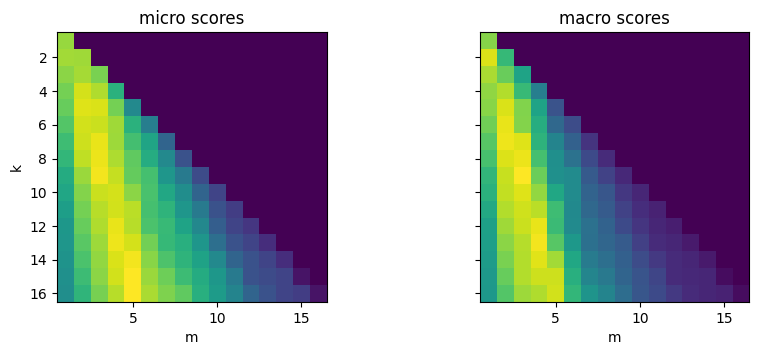

In [50]:

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [50]:

k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")


In [51]:
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create a FAISS index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

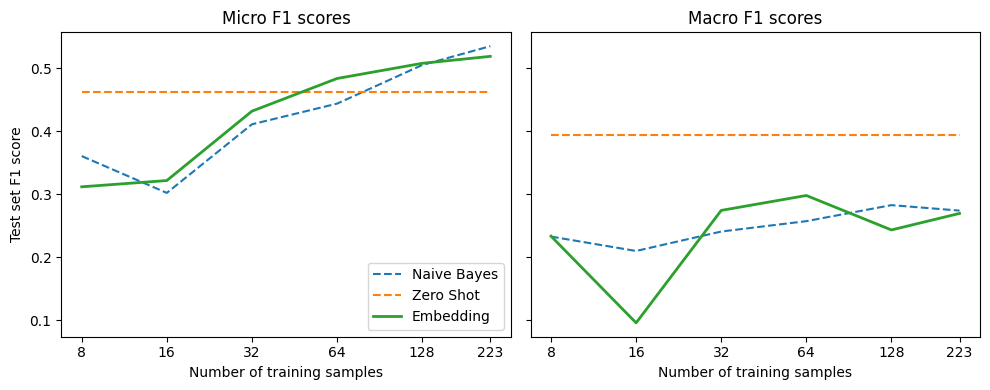

In [52]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")


When we want to find the most similar vectors in a database to a query vector, in theory we need to ompare the query vector to each of the n vectors in the database

- From a small database such as we ahve in this chapter, is no problem but if we scaled this up to thousands or even million of entires we would need to wait a while for each query to be processed


- FAISS addresses this issue with several tricks, the main idea is to paritition the dataset, if we only need to coompare the query vector to a subset of the database, we can speed up the profcess significantly.

- But if we randomly partitiion the dataset, how can we decide which partition to search, and what guarantees do we get for finding the most similar entries?

    - Apply k-mean clustering to the dataset, This clusters the embeddings into groups by similarity. Furhtermore, for each group we get centroid vector, whihc is the average of all members of the group


- Given such a grouping, searching among n vectors is much easier: we first search across the k centroid for the one that is most simialr to our query (k comparison) and then we search within the group (k/n elements to compare)

    - This reduces the numberof comparison from n to k+n/k.

    - What is the best option for k?
        - If k is too large there are many centroid we need to search through. Looking for the minimum of the function f(k)=k+n/k with respect to k, we find k=n^1/2



In [53]:
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [54]:
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)},
                    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [55]:

from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="./results", num_train_epochs=20, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0,
    evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model='micro f1',
    save_total_limit=1, log_level='error')

In [57]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)

    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]
            }

In [58]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],)

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.653300,0.615261,0.210526,0.095697
2,0.574800,0.552221,0.098592,0.050265
3,0.525500,0.508506,0.000000,0.000000
4,0.475100,0.474295,0.000000,0.000000
5,0.448600,0.448270,0.000000,0.000000
6,0.416800,0.427739,0.000000,0.000000
7,0.392300,0.410792,0.000000,0.000000
8,0.370300,0.399366,0.000000,0.000000
9,0.348100,0.389287,0.000000,0.000000
10,0.335900,0.381417,0.000000,0.000000


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.646900,0.577869,0.183267,0.097968
2,0.549800,0.506397,0.057143,0.020202
3,0.479700,0.480024,0.000000,0.000000
4,0.451400,0.435762,0.000000,0.000000
5,0.403000,0.418365,0.000000,0.000000
6,0.386200,0.391554,0.000000,0.000000
7,0.363100,0.381035,0.000000,0.000000
8,0.346200,0.371641,0.000000,0.000000
9,0.322400,0.368710,0.000000,0.000000
10,0.312000,0.361920,0.000000,0.000000


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.626600,0.546715,0.016129,0.020202
2,0.489400,0.446151,0.000000,0.000000
3,0.403600,0.402275,0.000000,0.000000
4,0.369700,0.381890,0.000000,0.000000
5,0.339500,0.364241,0.000000,0.000000
6,0.320600,0.357045,0.000000,0.000000
7,0.310300,0.350625,0.000000,0.000000
8,0.301800,0.343762,0.064000,0.028674
9,0.291600,0.359601,0.212766,0.070922
10,0.290300,0.352304,0.000000,0.000000


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.579300,0.478852,0.090909,0.038095
2,0.421500,0.385924,0.000000,0.000000
3,0.357600,0.357031,0.000000,0.000000
4,0.323200,0.335048,0.032258,0.015873
5,0.295000,0.322101,0.165414,0.066066
6,0.269600,0.317337,0.407643,0.161679
7,0.245000,0.294042,0.375839,0.154275
8,0.223900,0.295475,0.335570,0.127315
9,0.203200,0.282894,0.443038,0.174138
10,0.180900,0.271842,0.508671,0.228052


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.480000,0.381131,0.000000,0.000000
2,0.354300,0.342529,0.000000,0.000000
3,0.317200,0.328138,0.440476,0.166527
4,0.294200,0.308656,0.295775,0.118621
5,0.261600,0.291950,0.481928,0.183764
6,0.226900,0.264914,0.478528,0.184581
7,0.191500,0.244555,0.490798,0.220960
8,0.159200,0.248320,0.531792,0.265422
9,0.140100,0.227869,0.573034,0.346760
10,0.115400,0.235463,0.585635,0.363335


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.418500,0.349748,0.000000,0.000000
2,0.326500,0.322986,0.342466,0.139506
3,0.284800,0.273672,0.493976,0.188180
4,0.237100,0.244489,0.579545,0.302887
5,0.195900,0.231219,0.586957,0.317572
6,0.159700,0.206187,0.612022,0.329327
7,0.127600,0.210070,0.679803,0.565817
8,0.096700,0.196029,0.649746,0.466991
9,0.081200,0.194296,0.699029,0.593058
10,0.061300,0.210092,0.676768,0.554835


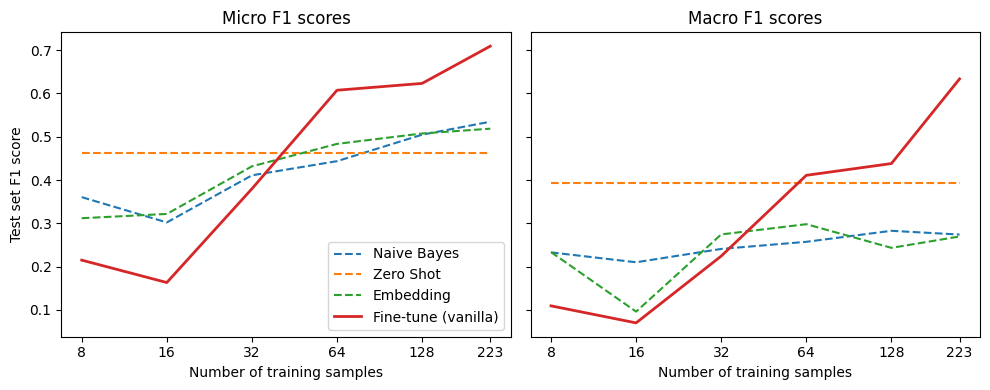

In [59]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")


## Leveraging Unlabeled Data

### Fine-Tuning a Language Model


- Two  extra concepts when tokenizing the data and a special data collator
    - In addition to th eordinary tokens from the text the tokenizer also adds special tokens too the sequence, such as the [CLS] and [SEP] tokens taht are used for classification and next sentence prediction.
    - Wehn. we do mask language modelling, we want to make sure we dont train the model to also predict these tokens.

    - For this reason we mask them from the loss, and we can get a mask when tokenizing by setting return_special_tokens_mask=True

In [60]:
#hide_output
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

- whas missing to start wiht masked languaeg modeling is hte mechanism to mask tokens in the input sequnece and have the target tokens in the outputs
    - One way we could deal wiith is by setting up a function that masks random tokens and creates labels for these sequences
    - But. this would be double the size of the dataset

    - We can use data collator:
        - A bathc is smapled form the dataset, and the data colaltor prepares the elements in the batch to feed them to the model
        - IN the simples casee we have encoutned it simple concatenates the tensors of each element into a singel tensor

        - In our case we can use it to do the masking and label geneeration on the fly

        That way we dont need to stor the labels and we get new masks every time we smaple. The data collator for this task is called DataCollatorForLanguageModelling
        -

In [61]:

from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)

In [62]:

set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])

original_input_ids = inputs["input_ids"][0]
masked_input_ids = outputs["input_ids"][0]

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(original_input_ids),
    "Masked tokens": tokenizer.convert_ids_to_tokens(masked_input_ids),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


In [63]:
data_collator.return_tensors = "pt"


In [67]:
from huggingface_hub import notebook_login

notebook_login()

In [69]:
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=True, log_level="error", report_to="none")

trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
        tokenizer=tokenizer, args=training_args, data_collator=data_collator,
        train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'loss': 2.0966, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.6190155744552612, 'eval_runtime': 9.7379, 'eval_samples_per_second': 22.9, 'eval_steps_per_second': 2.875, 'epoch': 1.0}
{'loss': 1.6197, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.5316603183746338, 'eval_runtime': 9.1535, 'eval_samples_per_second': 24.362, 'eval_steps_per_second': 3.059, 'epoch': 2.0}
{'loss': 1.485, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.4163991212844849, 'eval_runtime': 9.6529, 'eval_samples_per_second': 23.102, 'eval_steps_per_second': 2.901, 'epoch': 3.0}
{'loss': 1.3992, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.4063504934310913, 'eval_runtime': 8.4961, 'eval_samples_per_second': 26.247, 'eval_steps_per_second': 3.296, 'epoch': 4.0}
{'loss': 1.3219, 'learning_rate': 3.4375e-05, 'epoch': 5.0}
{'eval_loss': 1.3900213241577148, 'eval_runtime': 9.7558, 'eval_samples_per_second': 22.858, 'eval_steps_per_second': 2.87, 

TrainOutput(global_step=4656, training_loss=1.2789729927823306, metrics={'train_runtime': 19532.8383, 'train_samples_per_second': 7.62, 'train_steps_per_second': 0.238, 'train_loss': 1.2789729927823306, 'epoch': 16.0})

In [70]:
trainer.push_to_hub("Training complete!")


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

'https://huggingface.co/ckandemir/bert-base-uncased-issues-128/tree/main/'

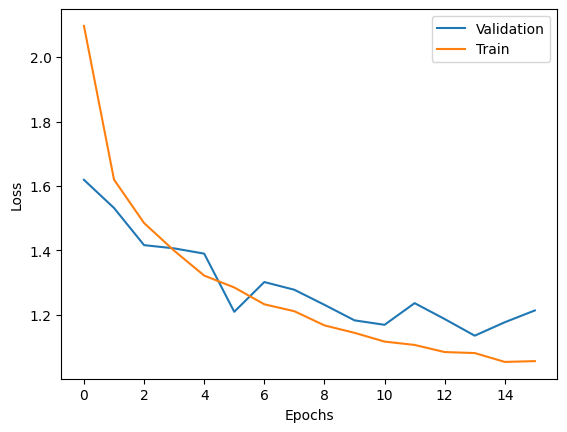

In [71]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [72]:
model_ckpt = f'{model_ckpt}-issues-128'
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    # DA refers to domain adaptation
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased-issues-128 and are newly initialized: ['classifier.bias', 'bert.pooler.dense.bias', 'classifier.weight', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.664800,0.585497,0.096970,0.050766
2,0.524400,0.496826,0.000000,0.000000
3,0.449300,0.448099,0.000000,0.000000
4,0.395900,0.417089,0.000000,0.000000
5,0.357100,0.398423,0.000000,0.000000
6,0.330300,0.386758,0.000000,0.000000
7,0.312000,0.378425,0.000000,0.000000
8,0.296500,0.372775,0.000000,0.000000
9,0.269200,0.369379,0.000000,0.000000
10,0.255000,0.365757,0.032258,0.014337


Some weights of the model checkpoint at bert-base-uncased-issues-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncase

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.601900,0.501861,0.016393,0.013072
2,0.440200,0.421392,0.000000,0.000000
3,0.375000,0.387679,0.000000,0.000000
4,0.335000,0.370472,0.000000,0.000000
5,0.310300,0.362437,0.000000,0.000000
6,0.284500,0.356376,0.000000,0.000000
7,0.259700,0.351133,0.000000,0.000000
8,0.242200,0.344650,0.048000,0.023226
9,0.223300,0.340810,0.062992,0.029091
10,0.199500,0.337313,0.093023,0.044030


Some weights of the model checkpoint at bert-base-uncased-issues-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncase

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.556500,0.446410,0.000000,0.000000
2,0.395700,0.385008,0.000000,0.000000
3,0.340700,0.364222,0.000000,0.000000
4,0.308000,0.352878,0.000000,0.000000
5,0.278100,0.341570,0.032520,0.016484
6,0.245300,0.331167,0.165414,0.076253
7,0.216500,0.325481,0.217391,0.097082
8,0.193200,0.317255,0.267606,0.115282
9,0.171700,0.315835,0.312925,0.179731
10,0.155800,0.309779,0.324324,0.183331


Some weights of the model checkpoint at bert-base-uncased-issues-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncase

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.496200,0.388972,0.000000,0.000000
2,0.360000,0.356597,0.000000,0.000000
3,0.324500,0.335384,0.000000,0.000000
4,0.285800,0.316393,0.258993,0.112476
5,0.248300,0.298376,0.351351,0.144716
6,0.205500,0.281420,0.425000,0.182916
7,0.170300,0.268427,0.463415,0.238205
8,0.144700,0.272098,0.468571,0.242424
9,0.123600,0.273709,0.483146,0.258922
10,0.108300,0.254474,0.502924,0.280136


Some weights of the model checkpoint at bert-base-uncased-issues-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncase

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.422200,0.354850,0.000000,0.000000
2,0.329300,0.318963,0.248175,0.092141
3,0.275700,0.280617,0.472727,0.180973
4,0.229600,0.244301,0.526946,0.253647
5,0.182500,0.217810,0.568182,0.303830
6,0.140800,0.203069,0.633333,0.409222
7,0.110300,0.194276,0.626374,0.390585
8,0.087700,0.190070,0.615385,0.403533
9,0.071100,0.180702,0.634409,0.429231
10,0.059700,0.182680,0.687500,0.495697


Some weights of the model checkpoint at bert-base-uncased-issues-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncase

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.391600,0.328434,0.195489,0.078078
2,0.298000,0.272180,0.509091,0.226162
3,0.229100,0.222509,0.590909,0.302333
4,0.167500,0.200191,0.652850,0.504850
5,0.118200,0.194227,0.659686,0.513899
6,0.084200,0.180408,0.696970,0.586681
7,0.063300,0.173412,0.705314,0.635041
8,0.049700,0.172589,0.718447,0.625744
9,0.040400,0.182454,0.706468,0.622971
10,0.034500,0.177520,0.708738,0.616822
